In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf




from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers

# from utils import *

from os.path import join as pjoin
import matplotlib as mpl
import glob
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Set some parameters
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3
# TRAIN_PATH = 'input/stage1_train/'
# TEST_PATH = 'input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
warnings.filterwarnings('ignore', category=UserWarning, module='numpy')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [106]:
%reload_ext autoreload
%autoreload 2 
from utils import *

### Preprocess train images

### Load dataset

In [2]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
 
DATA_DIR = pjoin(ROOT_DIR, 'data\TissueTraining')
print(DATA_DIR)

C:\Users\chladek\Documents\UCU DSS\Project
C:\Users\chladek\Documents\UCU DSS\Project\data\TissueTraining


In [3]:
# Get data
img_files = {}
mask_files = {}
cover_files = {}

img_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'OverviewBF*.png')))
mask_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'SampleMask*.png')))
cover_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'CoverslipMask*.png')))

train_ids = [580, 8, 4, 1, 39, 9, 12, 17, 2, 617, 568, 588, 159, 20, 13, 750, 3, 14, 22, 567, 10, 7, 21, 15, 11, 566,6]
val_ids = [18, 749, 16, 19, 519, 379, 5, 248]

img_files['train'] = [file for file in img_files['all'] if int(file[-8:-5]) in train_ids]
mask_files['train'] = [file for file in mask_files['all'] if int(file[-8:-5]) in train_ids]
cover_files['train'] = [file for file in cover_files['all'] if int(file[-8:-5]) in train_ids]

img_files['val'] = [file for file in img_files['all'] if int(file[-8:-5]) in val_ids]
mask_files['val'] = [file for file in mask_files['all'] if int(file[-8:-5]) in val_ids]
cover_files['val'] = [file for file in cover_files['all'] if int(file[-8:-5]) in val_ids]

TRAIN_SIZE = len(img_files['train'])
VAL_SIZE = len(img_files['val'])

In [ ]:
mpl.rcParams["figure.figsize"] = (10, 10)
PAD_SIZE = (0, 0)

covers_path = pjoin(DATA_DIR, 'covers')
if not os.path.exists(covers_path):
    os.mkdir(covers_path)

Img_files = {}
Mask_files = {}
for data_mode in ['train', 'val']:
    print('{} SET:'.format(data_mode.upper()))
    Img_files[data_mode] = []
    Mask_files[data_mode] = []
    
    for i, (img_file, cover_file, mask_file) in \
                enumerate(zip(img_files[data_mode],
                              cover_files[data_mode],
                              mask_files[data_mode])):

        img = imread(img_file)
        cover = imread(cover_file)
        mask = imread(mask_file)
        
        new_img = get_cover(img, cover, PAD_SIZE)
        new_mask = get_cover(mask, cover, PAD_SIZE)
        new_mask[new_mask>1] = 1
        
        Img_file = pjoin(covers_path, 'IMG{}'.format(cover_file[-10:]))
        Mask_file = pjoin(covers_path, 'MASK{}'.format(cover_file[-10:]))
        imsave(Img_file, new_img)
        imsave(Mask_file, new_mask)
        Img_files[data_mode].append(Img_file)
        Mask_files[data_mode].append(Mask_file)
        
    print('\n'.join(Img_files[data_mode]))
    print('\n'.join(Mask_files[data_mode]))

#### Generate patches

In [ ]:
# ls data/patches/001/
# from utils import *

from albumentations import (RandomRotate90, GaussNoise, ElasticTransform, ChannelShuffle, 
                            Flip, IAAAdditiveGaussianNoise, OneOf)

In [ ]:
# aug = Flip(p=1)(**data,d=np.random.randint(2))
# patch_1, mask_1 = aug(image=)

In [ ]:
def create_augm(patch, mask, path_patch, path_mask):
    data = {'image':patch, 'mask':mask}
    
    aug = Flip(p=1)(**data,d=np.random.randint(2))
    patch_1, mask_1 = aug['image'], aug['mask']
    
    aug = RandomRotate90(p=1)(**data,factor=np.random.randint(3)+1)
    patch_2, mask_2 = aug['image'], aug['mask']
    
    aug = ChannelShuffle(p=1)(**data) # image
    patch_3, mask_3 = aug['image'], mask
    
    aug = ElasticTransform(p=1)(**data)
    patch_4, mask_4 = aug['image'], aug['mask']
    
    aug = Gauss_aug()(**data) # image
    patch_5, mask_5 = aug['image'], mask
    
    
    for counter,file in enumerate([patch, patch_1,patch_2,patch_3,patch_4,patch_5]):
        imsave(path_patch + str(counter) +  '.png', file)
    for counter,file in enumerate([mask, mask_1, mask_2, mask_3, mask_4, mask_5]):
        imsave(path_mask + str(counter) + '.png', file)
#         imsave(newpath + '\PATCH_'+ str(patch_number) + '_' + str(counter) + '.png' ,file)

def Gauss_aug(p=1,scale=0.025*255,var_limit=(10, 50)):
    return OneOf([
            IAAAdditiveGaussianNoise(p=p,scale=scale),
            GaussNoise(p=p,var_limit=var_limit),
        ], p=p)

In [ ]:
PATCHES = 3000
for img_file, mask_file in zip(Img_files['train'],
                                   Mask_files['train']):
        folder_name = img_file.split('_')[-2]
        if not os.path.exists('data/patches/{0}'.format(folder_name)):
            os.makedirs('data/patches/{0}'.format(folder_name))
        img, mask = imread(img_file), imread(mask_file)
        coords = get_coord(img.shape[0], img.shape[1], PATCHES)
        bbxs = coord_to_bbx(coords, img)
        patches = get_patches(img, mask, bbxs)
        for id_, patch_n_mask in tqdm(enumerate(patches)):
            patch, mask_patch = patch_n_mask
            imsave('data/patches/{}/PATCH_{}.png'.format(folder_name, id_), patch)
            imsave('data/patches/{}/MASK_{}.png'.format(folder_name, id_), mask_patch)
            create_augm(patch,
                        mask_patch, 
                        'data/patches/{}/PATCH_{}_'.format(folder_name, id_),
                        'data/patches/{}/MASK_{}_'.format(folder_name, id_))
        print('Created patches for {} tissue'.format(folder_name, id_))

print('Done!')

#### Load patches 

In [ ]:
def read_tissue(path):
    "Reading of patches of one image"
    files = sorted(os.listdir(path))
    masks, patches = files[:int(len(files) / 2)], files[int(len(files) / 2):]
    return ([imread(os.path.join(path, patch)) for patch in patches],
            [np.expand_dims(imread(os.path.join(path, mask), as_gray=True)*255, axis=2) for mask in masks])

def read_dataset():
    "Reading all dataset"
    X, y = [], []
    for tissue in os.listdir('data/patches/'):
        patches, masks = read_tissue(os.path.join('data/patches/', tissue))
        X, y = X + patches, y + masks
    return np.asarray(X), np.asarray(y)

X_train, Y_train = read_dataset()

In [8]:
from keras import metrics as keras_metrics

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

### Test images

In [9]:
from skimage.io import imread, imshow, imread_collection, concatenate_images


In [10]:
def print_nuclei_bg_acc(gt, pred):
    """Print overall, nuclei, and background accuracies"""   
    tp = np.sum(1*np.logical_and(gt, pred)) #TP
    tn = np.sum(1*np.logical_and(np.logical_not(gt), np.logical_not(pred))) #FP
    fp = np.sum(1*np.logical_and(np.logical_not(gt), pred)) #FP
    fn = np.sum(1*np.logical_and(gt, np.logical_not(pred))) #FP
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)    
    print("accuracy: %s, recall: %s, precision: %s, specificity: %s" % (accuracy, recall, precision, specificity))

In [11]:
def get_cords_patch(img):
    coords = []
    for x in range(0, img.shape[1], 64):
         for y in range(0, img.shape[0], 64):
                coords.append([x, y])
    return coords


#coords_res = get_cords_patch(res)
# print(coords_res)
#bbxs = coord_to_bbx(coords_res, res)

# imshow(bbxs.draw_on_image(res, thickness=2, color=[0, 0, 255]))
#t = get_patches(res, res_mask, bbxs)

# Test of Evaluation pipeline

In [12]:
# Loading all test images and masks
X_test = []
Y_test = []
for x,y in zip(Img_files['val'],Mask_files['val']):
    X_test.append(imread(x))
    Y_test.append(np.expand_dims(imread(y, as_gray=True), axis=2))

X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

In [71]:
img = X_test[1]

In [ ]:
imshow(img)

In [31]:
height = img.shape[0]
width = img.shape[1]
shape = 64
###
add_height = shape*(int(height/shape) + int((height % shape)>0))-height
add_width = shape*(int(width/shape) + int((width % shape)>0))-width

In [32]:
### Add borders
#https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html
BLUE = [0,0,0]
constant=cv2.copyMakeBorder(img,0,add_height,0,add_width,cv2.BORDER_CONSTANT,value=BLUE)

In [33]:
### Create patches
coords_res = get_cords_patch(constant)
# print(coords_res)
bbxs = coord_to_bbx(coords_res, constant)

# imshow(bbxs.draw_on_image(res, thickness=2, color=[0, 0, 255]))
t = get_patches(constant,constant, bbxs)

Test = []
Mask = []

for pair in t:
    Test.append(pair[0])
    Mask.append(np.expand_dims(pair[1], axis=2))

Test = np.asarray(Test)
Mask = np.asarray(Mask)
print(Test.shape)
print(Mask.shape)

(98, 64, 64, 3)
(98, 64, 64, 1, 3)


In [34]:
### Predictions for all patches
showup = (model.predict(Test)>0.5).astype(np.uint8)

In [77]:
showup = model.predict(Test)

In [ ]:
### Merging predicted patches to image
im  = '\\Predictions\\0\\'

full_height = add_height + height
full_width = add_width + width
new_img = np.zeros(shape=(full_height, full_width, 1))
col = 0
j=0

for i in range(len(Test)):
    j = i % int(full_height/shape)
    col += ((i % int(full_height/shape))==0 and i!=0)
    
    new_img[j*shape:(j+1)*shape,col*shape:(col+1)*shape,:] = showup[i]
    print(i)
    #imshow(np.squeeze(new_img.astype(int)))
    #plt.show()

final_img = (new_img[:height, :width,:])#.astype(int)    

In [92]:
def IoU(mask_gt, mask_pred):
    return (mask_gt * mask_pred).sum() / (np.maximum(mask_gt, mask_pred)).sum() * 100 

def Precision(mask_gt, mask_pred):
    return (mask_gt * mask_pred).sum() / mask_pred.sum() * 100 

def Recall(mask_gt, mask_pred):
    return (mask_gt * mask_pred).sum() / mask_gt.sum() * 100 

In [ ]:
mask_array = np.squeeze(final_img)
plt.subplot(1,3,1)
imshow(img)
plt.subplot(1,3,2)
imshow(mask_array)

#mask_array = crop_image(mask_array, pads)
#image = crop_image(img, pads)
mask_pred = (mask_array > 0.5).astype(np.uint8)
plt.subplot(1,3,3)
imshow(mask_overlay(img, mask_pred))
plt.show()

iou = IoU(np.squeeze(true), mask_pred)
#ious.append(iou)
print('IoU: {:.2f}%'.format(iou))
precision = Precision(np.squeeze(true), mask_pred)
#precisions.append(precision)
print('Precision: {:.2f}%'.format(precision))
recall = Recall(np.squeeze(true), mask_pred)
#recalls.append(recall)
print('Recall: {:.2f}%'.format(recall))

In [ ]:
pred_final = []
true_final = []
mpl.rcParams['figure.figsize'] = (20, 20)

ious = []
precisions = []
recalls = []

for x in range(len(X_test)):
    #print('Test image ',x)
    img = X_test[x]
    #######################
    height = img.shape[0]
    width = img.shape[1]
    shape = 64
    #
    add_height = shape*(int(height/shape) + int((height % shape)>0))-height
    add_width = shape*(int(width/shape) + int((width % shape)>0))-width
    
    ######################
    BLUE = [0,0,0]
    constant=cv2.copyMakeBorder(img,0,add_height,0,add_width,cv2.BORDER_CONSTANT,value=BLUE)
    #imshow(constant)
    
    ######################
    
    coords_res = get_cords_patch(constant)
    # print(coords_res)
    bbxs = coord_to_bbx(coords_res, constant)

    # imshow(bbxs.draw_on_image(res, thickness=2, color=[0, 0, 255]))
    t = get_patches(constant,constant, bbxs)

    Test = []
    #Mask = []

    for pair in t:
        Test.append(pair[0])
        #Mask.append(np.expand_dims(pair[1], axis=2))

    Test = np.asarray(Test)
    #Mask = np.asarray(Mask)
    #print(Test.shape)
    #print(Mask.shape)
    
    ########################################
    
    showup = model.predict(Test)
    
    ### Merging predicted patches to image

    full_height = add_height + height
    full_width = add_width + width
    new_img = np.zeros(shape=(full_height, full_width, 1))
    col = 0
    j=0
    i=0
    for i in range(len(Test)):
        j = i % int(full_height/shape)
        col += ((i % int(full_height/shape))==0 and i!=0)

        new_img[j*shape:(j+1)*shape,col*shape:(col+1)*shape,:] = showup[i]
        #print(i)
        #imshow(np.squeeze(new_img.astype(int)))
        #plt.show()

    final_img = (new_img[:height, :width,:])#.astype(int)
    
    #########################################
    preds = final_img
    true = (Y_test[x]>0).astype(np.uint8)
    #print_nuclei_bg_acc(true,preds)
    
    # Plot stuff
    #f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    #f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    #ax1.imshow(X_test[x])
    #ax2.imshow(np.squeeze(final_img))
    #ax3.imshow(np.squeeze(Y_test[x]))
    #ax1.set_title('Test image')
    #ax2.set_title('Predicted image')
    #ax3.set_title('Mask')
    #plt.show()
    
    
    #pred_final = np.append(pred_final,preds.ravel())
    #true_final = np.append(true_final,true.ravel())
    #print('Cummulative performance until',x)
    #print_nuclei_bg_acc(true_final,pred_final)
    
    #############################################
    ### Stuff from Yaroslava train
    mask_array = np.squeeze(final_img)
    plt.subplot(1,3,1)
    imshow(img)
    plt.subplot(1,3,2)
    imshow(mask_array)

    #mask_array = crop_image(mask_array, pads)
    #image = crop_image(img, pads)
    mask_pred = (mask_array > 0.5).astype(np.uint8)
    plt.subplot(1,3,3)
    imshow(mask_overlay(img, mask_pred))
    plt.show()

    iou = IoU(np.squeeze(true), mask_pred)
    ious.append(iou)
    print('IoU: {:.2f}%'.format(iou))
    precision = Precision(np.squeeze(true), mask_pred)
    precisions.append(precision)
    print('Precision: {:.2f}%'.format(precision))
    recall = Recall(np.squeeze(true), mask_pred)
    recalls.append(recall)
    print('Recall: {:.2f}%'.format(recall))
    

In [125]:
Ious = np.array(ious) / 100
Precisions = np.array(precisions) / 100
Recalls = np.array(recalls) / 100
print('\tMean IoU: {:.3f}\n\tMean precision: {:.3f}\n\tMean recall: {:.3f}'.format(Ious.mean(), Precisions.mean(), Recalls.mean()))

	Mean IoU: 0.881
	Mean precision: 0.942
	Mean recall: 0.930


	Mean IoU: 0.881


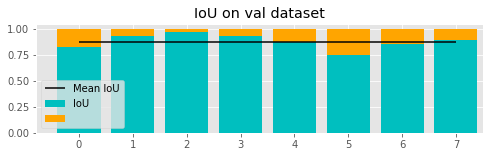

	Mean precision: 0.942


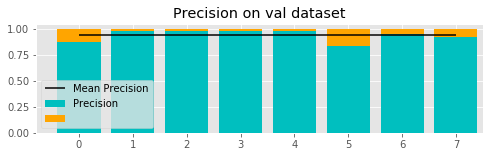

	Mean recall: 0.930


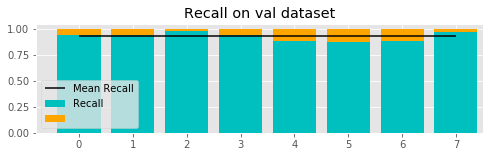

In [126]:
plt.style.use('ggplot')
mpl.rcParams["figure.figsize"] = (8, 2)
plot_ratio(Ious, 'IoU on val dataset', ['IoU', ''])
print('\tMean IoU: {:.3f}'.format(Ious.mean(), Precisions.mean(), Recalls.mean()))
plt.show()
plot_ratio(Precisions, 'Precision on val dataset', ['Precision', ''])
print('\tMean precision: {:.3f}'.format(Precisions.mean(), Recalls.mean()))
plt.show()
plot_ratio(Recalls, 'Recall on val dataset', ['Recall', ''])
print('\tMean recall: {:.3f}'.format(Recalls.mean()))
plt.show()

## U-net

In [123]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# precision = as_keras_metric(tf.metrics.precision)
# recall = as_keras_metric(tf.metrics.recall)
# model.compile(loss='mean_squared_error', optimizer=sgd)
model.load_weights('model-dsbowl2018-2_lr_001_batch_64.h5')
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=[auc_pr])

# model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=[keras_metrics.precision(), keras_metrics.recall()])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 64, 64, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 64, 64, 8)    224         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 64, 64, 8)    584         conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [ ]:
earlystopper = EarlyStopping(patience=30, verbose=1)
if not os.path.exists('model_weights'):
    os.makedirs('model_weights')
checkpointer = ModelCheckpoint('model_weights/model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=512, epochs=50, 
                    callbacks=[checkpointer])

In [ ]:
model = load_model('model-dsbowl2018-2.h5',
                    custom_objects={'auc_pr': auc_pr})

In [ ]:
model = load_model('model_weights/model-dsbowl2018-2.h5',
                    custom_objects={'auc_pr': auc_pr})
# model = load_model('model_weights/model-dsbowl2018-1_PR.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))